# On Shaky Ground

## Earthquakes in Asia

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [2]:
# Just a quick value_counts function I made for use during development.

def vc (dataframe : pd.DataFrame, column : str, print_all = False):
    if print_all:
        for category in dataframe.columns.values.tolist():
            print(category.upper())
            print(dataframe[category].value_counts())
            print()
    else:
        print(column.upper())
        print(dataframe[column].value_counts())

In [3]:
df = pd.read_csv('data/Significant_Earthquakes_1965-2016.csv')

In [4]:
df['Date_Time'] = df['Date'] + ' ' + df['Time']

In [5]:
df_dt = df.drop('Date', axis=1).drop('Time', axis=1)

In [6]:
dt = df_dt['Date_Time']
df_dt.drop('Date_Time', axis=1, inplace=True)
df_dt = pd.concat([dt, df_dt], axis=1)

In [7]:
#Rows 3378, 7512, 20650 have date-times in a different format, so we'll drop them.
df_dt['Date_Time'][20650]

'2011-03-13T02:23:34.520Z 2011-03-13T02:23:34.520Z'

In [8]:
df_dt.drop([3378,7512,20650], inplace=True)

In [9]:
df_dt['Date_Time'] = pd.to_datetime(df_dt['Date_Time'])
df_dt.reset_index(drop=True)

,Date_Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,1965-01-02 13:44:18,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,1965-01-04 11:29:49,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,1965-01-05 18:05:58,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,1965-01-08 18:49:43,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,1965-01-09 13:32:50,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23404,2016-12-28 08:22:12,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,0.320,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed
23405,2016-12-28 09:13:47,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,0.260,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed
23406,2016-12-28 12:38:51,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,NaN,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed
23407,2016-12-29 22:30:19,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,NaN,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed


In [10]:
#dropping all entries that are not actual Earthquakes (no Nuclear Explosions, Explosions or Rock Bursts)
df_eq = df_dt[df_dt['Type'] == 'Earthquake'].reset_index(drop=True)

In [11]:
'''Multiple columns are missing too much data, so I will drop them here, "Type" is dropped because
all entries are "Earthquake" due to the way the data have thus far been processed.'''


drop_cols = ['Type','Depth Error','Depth Seismic Stations','Magnitude Error','Magnitude Seismic Stations','Azimuthal Gap',\
            'Horizontal Distance','Horizontal Error','Root Mean Square']

df_trim = df_eq.drop(drop_cols, axis=1)

In [12]:
'''
Only keeping entries from categorical columns with > 50 entries:
Magnitude Type:  MW,MWC,MB,MWB,MWW,MS,ML
Source:  US,ISCGEM,ISCGEMSUP,GCMT,NC
Location Source:  US,ISCGEM,GCMT,NC
Magnitude Source:  US,HRV,ISCGEM,GCMT,NC
'''

magtype = ['MW','MWC','MB','MWB','MWW','MS','ML']
source = ['US','ISCGEM','ISCGEMSUP','GCMT','NC']
locsrc = ['US','ISCGEM','GCMT','NC']
magsrc = ['US','HRV','ISCGEM','GCMT','NC']

In [13]:
df_trunc = df_trim[df_trim['Magnitude Type'].isin(magtype)]
df_trunc = df_trunc[df_trunc['Source'].isin(source)]
df_trunc = df_trunc[df_trunc['Location Source'].isin(locsrc)]
df_trunc = df_trunc[df_trunc['Magnitude Source'].isin(magsrc)]
df_trunc = df_trunc.reset_index(drop=True)

23412 entries to start.  Now that this has been cleaned up extensively, we have dropped down
to 22820 entries.  This is a loss of 592 entries, or 2.5%, so we have only trimmed off 2.5%
of the starting data.  I believe this is acceptable, based on the ~5% max that I'\ve been told
previously (although even this has been a bit inconsistent, but this is still a good number here).

## Earthquake Map

In [14]:
# Labels used for specifying axis ticks, depending on how many I wanted
lat_15 = [-90,-75,-60,-45,-30,-15,0,15,30,45,60,75,90]
lat_30 = [-90,-60,-30,0,30,60,90]
long_15 = [-180,-165,-150,-135,-120,-105,-90,-75,-60,-45,-30,-15,0,
           15,30,45,60,75,90,105,120,135,150,165,180]
long_30 = [-180,-150,-120,-90,-60,-30,0,
           30,60,90,120,150,180]

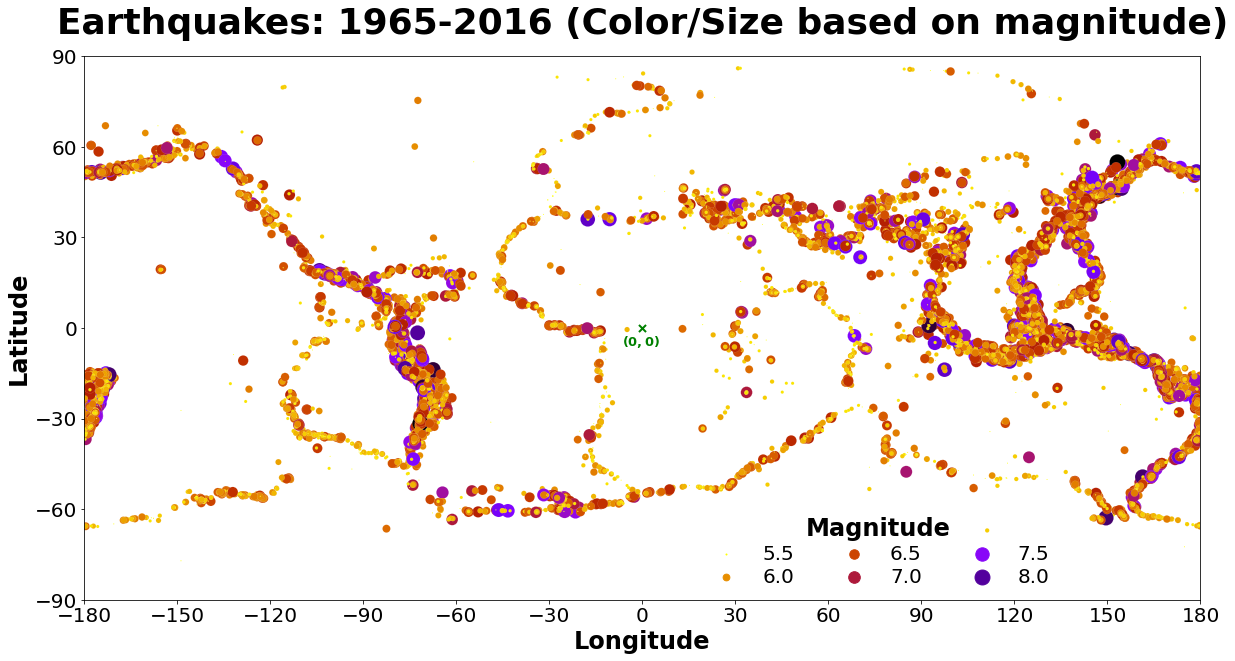

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_trunc['Longitude'], y=df_trunc['Latitude'], hue=df_trunc['Magnitude'],
                size=df_trunc['Magnitude'], sizes=(1,250),marker='o',palette='gnuplot_r')
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor='black')
plt.setp(legend.get_title(), color ='black', fontweight='bold')
ax.scatter(x=0,y=0, marker='x', c='green', s=(50), linewidths=2)
plt.annotate(xy=(-6.5,-6), text='$\\bf{(0,0)}$', fontsize=13, c='green')
ax.set_ylim([-90,90])
plt.title('Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/earthquake_map_binned_magn_125_dots_black.png', transparent=True, dpi=300)

## Feature Engineering

I want to see if binning this by month will do anything to bring results out, so I am going to attempt that here.

In [16]:
df_binned = df_trunc.copy()
df_binned['Month'] = pd.DatetimeIndex(df_binned['Date_Time']).month

Trying the same thing, but with Seasons, to see if that has any effect

In [17]:
season = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring', 4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
         7 : 'Summer', 8 : 'Summer', 9 : 'Fall', 10 : 'Fall', 11 : 'Fall', 12 : 'Winter'}

df_binned['Season'] = df_binned['Month'].map(season)

## Binning Magnitude to make a time-series model

In [18]:
df_magn = df_binned.copy()

def mag_bin(mag : float) -> int:
    
    #This function helps bin magnitude into a few different ranges
    
    if mag >= 5.5 and mag < 6:
        bins = 1
    elif mag >= 6 and mag < 7:
        bins = 2
    elif mag >= 7 and mag < 8:
        bins = 3
    else:
        bins = 4
    return bins

df_magn['Magn_Binned'] = df_magn['Magnitude'].apply(mag_bin)

## A function is needed to grab country names based on Lats/Longs

In [19]:
'''
This is only used once to create the csv.  Do not use again

# !pip install reverse_geocoder
# import reverse_geocoder as rg
# from pandas import DataFrame

# def reverseGeocode(coordinates):
#     return rg.search(coordinates)

'''

'\nThis is only used once to create the csv.  Do not use again\n\n# !pip install reverse_geocoder\n# import reverse_geocoder as rg\n# from pandas import DataFrame\n\n# def reverseGeocode(coordinates):\n#     return rg.search(coordinates)\n\n'

# This next line grabs lots of info, based on Lat/Long.  It takes hours to run!!  The one run I made was saved as 'data/df_countries.csv', so use that for anything necessary!

# AND DO NOT UN-COMMENT IT OR I WILL COME FOR YOUR SOUL!

In [20]:
# DO NOT UNCOMMENT UNLESS YOU HAVE A FEW HOURS TO SPARE!!
'''
df_countries = df_magn.copy()
# df_countries['Country'] = df_countries['Lat_Long'].apply(reverseGeocode)
'''

"\ndf_countries = df_magn.copy()\n# df_countries['Country'] = df_countries['Lat_Long'].apply(reverseGeocode)\n"

In [21]:
# This saved the csv I made above.  DO NOT UNCOMMENT or I will cry.
'''# df_countries.to_csv('data/df_countries.csv')'''

"# df_countries.to_csv('data/df_countries.csv')"

In [22]:
# This reads in the csv that was spit out above, so it can be used freshly each time, and
#  we don't have to worry about reprocessing anything

df_countries = pd.read_csv('data/df_countries.csv')

In [23]:
# The Data from the above mining only provides the country code(cc), in the middle of a long string,
#     So the cc must be extracted as a string, and then converted

# !pip install country_converter
import country_converter as coco

def get_cc (info_string : str) -> str:
    cc_pre = (info_string.split("'cc': '",1)[1])
    cc = cc_pre[:-3]
    return cc

def convert_cc (cc : str) -> str:
    name = coco.convert(names=cc, to='name_short')
    return name

In [24]:
# First we will trim off the unnecessary bits of each string, to get just the cc code:

df_countries['Country_Code'] = df_countries['Country'].apply(get_cc)

In [25]:
# Next, convert all the cc's from above to actual Country names:

'''
# Don't run the following.  It has already been completed and a csv has been saved:
("fixed_countries.csv)")

# Now convert cc to country names

# df_countries['Country'] = df_countries['Country_Code'].apply(convert_cc)
'''

'\n# Don\'t run the following.  It has already been completed and a csv has been saved:\n("fixed_countries.csv)")\n\n# Now convert cc to country names\n\n# df_countries[\'Country\'] = df_countries[\'Country_Code\'].apply(convert_cc)\n'

In [26]:
# Save the output df

'''
# Do not un-comment the following.  It saved the above converted df.  It should just be
# imported at this point.

# df_countries.to_csv('data/fixed_countries.csv')
'''

"\n# Do not un-comment the following.  It saved the above converted df.  It should just be\n# imported at this point.\n\n# df_countries.to_csv('data/fixed_countries.csv')\n"

In [27]:
# Freshly read in the "fixed" df calculated, and saved above

df_countries = pd.read_csv('data/fixed_countries.csv')

### Now we can identify each earthquake as occurring in asia, by using the following function to check for presence in the following [list of asian countries](https://www.countries-ofthe-world.com/countries-of-asia.html):

In [28]:
def is_asian(country):
    asia = ['Afghanistan','Armernia','Azerbaijan','Bahrain','Bangladesh','Bhutan','Brunei',
           'Cambodia','China','Cyprus','Georgia','India','Indonesia','Iran','Irag','Israel',
           'Japan','Jordan','Kazakhstan','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia',
           'Maldives','Mongolia','Myanmar','Nepal','North Korea','Oman','Pakistan','Palestine',
           'Philippines','Qatar','Russia','Saudi Arabia','Singapore','South Korea','Sri Lanka',
           'Syria','Taiwan','Tajikistan','Thailand','Timor-Leste','Turkey','Turkmenistan','UAE',
           'United Arab Emirates','United Arab Emirates (UAE)','Uzbekistan','Vietnam','Yemen']
    if country in asia:
        asian = 1
    else:
        asian = 0
    return asian

In [29]:
df_countries['In_Asia'] = df_countries['Country'].apply(is_asian)

In [30]:
total_earthquakes = len(df_countries)
asian_earthquakes = df_countries['In_Asia'].value_counts()[1]
non_asian_earthquakes = df_countries['In_Asia'].value_counts()[0]
percent_asian = round(df_countries['In_Asia'].value_counts('1')[1] * 100, 2)

print('There are ' + str(total_earthquakes) + ' earthquakes in the initial data set.')
print(str(asian_earthquakes) + ' of these occurred in Asian countries,')
print('leaving ' + str(non_asian_earthquakes) + ' occurring in the rest of the world.')
print('This means that earthquakes in Asia accounted for ' + str(percent_asian) + '% of the\
 world total from 1965 through 2016.')

There are 22820 earthquakes in the initial data set.
8804 of these occurred in Asian countries,
leaving 14016 occurring in the rest of the world.
This means that earthquakes in Asia accounted for 38.58% of the world total from 1965 through 2016.


In [31]:
df_asian = df_countries[df_countries['In_Asia'] == 1].reset_index(drop=True)

In [32]:
#  Oops!  Extra indices from the two "big" engineered features.  Dropping:

drop_indices = ['Unnamed: 0','Unnamed: 0.1']
df_asian = df_asian.drop(drop_indices, axis=1)

### Plot of Asian Earthquakes

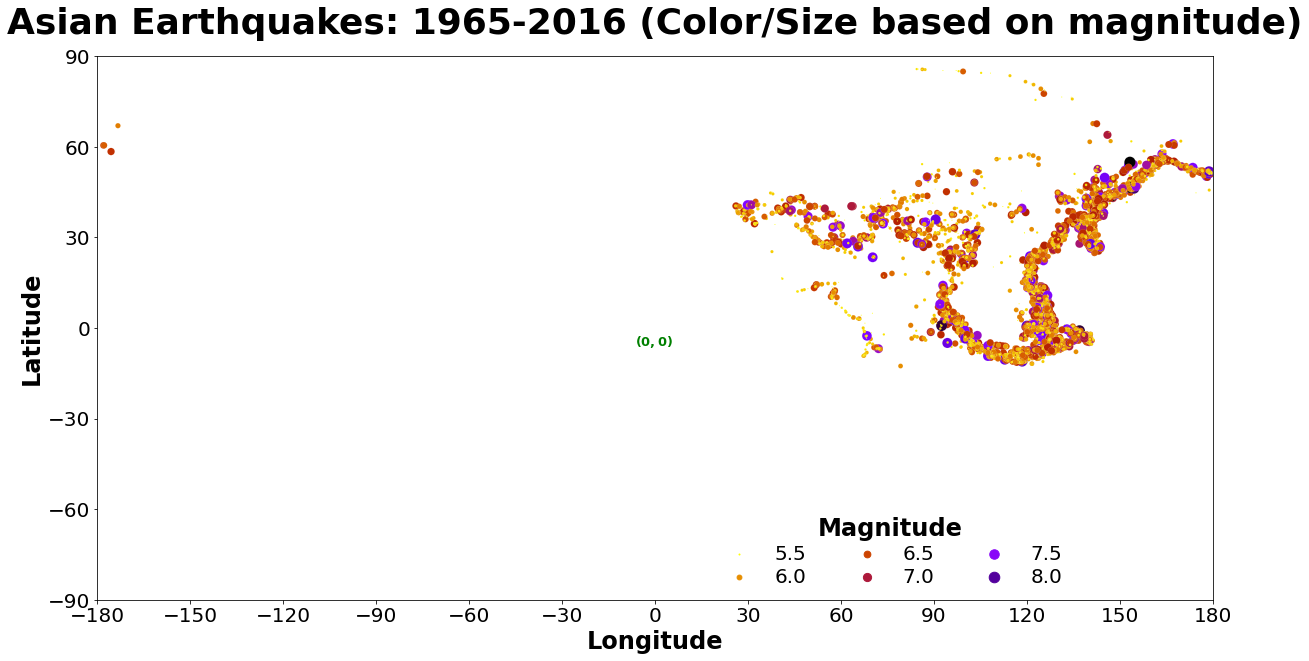

In [33]:
# For a plot in the slideshow, I want to zoom in on just the asian earthquakes:

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df_asian['Longitude'], y=df_asian['Latitude'], hue=df_asian['Magnitude'],
                size=df_asian['Magnitude'], sizes=(1,125),marker='o',palette='gnuplot_r')
legend = plt.legend(title='Magnitude', title_fontsize=24, fontsize=20, labelspacing=0.2,
                loc=(0.55,0.01), ncol=3, frameon=False, labelcolor='black')
plt.setp(legend.get_title(), color ='black', fontweight='bold')
plt.annotate(xy=(-6.5,-6), text='$\\bf{(0,0)}$', fontsize=13, c='green')
ax.set_ylim([-90,90])
plt.title('Asian Earthquakes: 1965-2016 (Color/Size based on magnitude)', fontsize=36,
          fontweight='bold', y=1.03)
plt.xlabel('Longitude', fontsize=24, fontweight='bold')
plt.yticks(lat_30, fontsize=20)
ax.set_xlim([-180,180])
plt.ylabel('Latitude', fontsize=24, fontweight='bold')
plt.xticks(ticks=(long_30), fontsize=20);
# plt.savefig('images/earthquake_map_asian_black_125dot.png', transparent=True, dpi=300)

#### Somehow, the Date_Time column was re-converted to "object" so I'll fix that now, and since we'll be doing Time-Series, I'll start setting up the Series necessary to show binned magnitudes over time:

In [34]:
df_asian['Date_Time'] = pd.to_datetime(df_asian['Date_Time']).reset_index(drop=True)

In [35]:
# df_asian_Mag1 = df_asian[df_asian['Magn_Binned'] == 1].reset_index(drop=True)
# df_asian_Mag2 = df_asian[df_asian['Magn_Binned'] == 2].reset_index(drop=True)
# df_asian_Mag3 = df_asian[df_asian['Magn_Binned'] == 3].reset_index(drop=True)
# df_asian_Mag4 = df_asian[df_asian['Magn_Binned'] == 4].reset_index(drop=True)

In [36]:
# mag1_ts = pd.Series(df_asian_Mag1.set_index(df_asian_Mag1['Date_Time'])['Magnitude'])
# mag2_ts = pd.Series(df_asian_Mag2.set_index(df_asian_Mag2['Date_Time'])['Magnitude'])
# mag3_ts = pd.Series(df_asian_Mag3.set_index(df_asian_Mag3['Date_Time'])['Magnitude'])
# mag4_ts = pd.Series(df_asian_Mag4.set_index(df_asian_Mag4['Date_Time'])['Magnitude'])

In [37]:
# mag4_ts

### Now that I have all the ranges of magnitudes of earthquakes in time-series form, I can start playing with them and plotting them!

In [38]:
# Taking the sum of earthquakes for each magnitude range, over a 1 month period through this time range
# monthly_mag1 = mag1_ts.resample('M').sum()
# monthly_mag2 = mag2_ts.resample('M').sum()
# monthly_mag3 = mag3_ts.resample('M').sum()
# monthly_mag4 = mag4_ts.resample('M').sum()

In [39]:
# fig, ax = plt.subplots(figsize=(17,13))
# monthly_mag1.plot(ax = ax, ylabel='Counts')
# monthly_mag2.plot(ax = ax)
# monthly_mag3.plot(ax = ax)
# monthly_mag4.plot(ax = ax)
# legend = plt.legend(title='Magnitude Ranges', title_fontsize=24, fontsize=20,
#                     frameon=False, loc='best', labels=['5.5 - 6','6 - 7','7 - 8','8+'])
# plt.setp(legend.get_title(), fontweight='bold')
# plt.title('Asian Earthquakes: 1965-2016 (Frequency / Month)', fontsize=36,
#           fontweight='bold', y=1.03)
# plt.xlabel('Date', fontsize=24, fontweight='bold')
# plt.xticks(fontsize=20)
# plt.ylabel('Earthquake Frequency', fontsize=24, fontweight='bold')
# plt.yticks(fontsize=20);


# I started to plot each magnitude range individually, but, per a 1:1 with Max Barry, and his suggestion that the magnitudes should not be binned (due to low N's for the larger earthquakes), I did not finish these plots.

In [40]:
# fig, axes = plt.subplots(4,1, figsize=(17,26), tight_layout=True)

# for ax in axes:
#     ax.set_ylabel('Earthquake Frequency', fontsize=24, fontweight='bold')

# ax = axes[0]
# ax.set_title('Asian Earthquakes: 1965-2016 (Frequency / Month)', fontsize=36,
#           fontweight='bold', y=1.03)
# ax.plot(weekly_mag1)
# ax.set_xlabel('')
# ax.set_ylabel('Frequency', fontsize=24, fontweight='bold')





# legend = plt.legend(title='Magnitude Range', title_fontsize=24, fontsize=20,
#                     frameon=False, loc='best', labels=['5.5 - 6','6 - 7','7 - 8','8+'])
# plt.setp(legend.get_title(), fontweight='bold')
# plt.xlabel('Date', fontsize=24, fontweight='bold')
# plt.xticks(fontsize=20)
# plt.ylabel('Earthquake Frequency', fontsize=24, fontweight='bold')
# plt.yticks(fontsize=20);

# weekly_mag2.plot(ax = ax);
# weekly_mag3.plot(ax = ax);
# weekly_mag4.plot(ax = ax);
# ;

# For right now, I'm moving on to some suggestions that Max Barry, subbing for Jelly, gave to me.  Can come back to the above, later, if necessary

In [41]:
# Going to look at all points together, instead of binning the magnitude ranges, per Max

asian_ts = pd.Series(df_asian.set_index(df_asian['Date_Time'])['Magnitude'])

# And now we'll resample to Monthly sum and see how it looks

monthly_sum_asian = asian_ts.resample('M').sum()

# We'll make a Monthly mean now too for funsies

monthly_mean_asian = asian_ts.resample('M').mean()


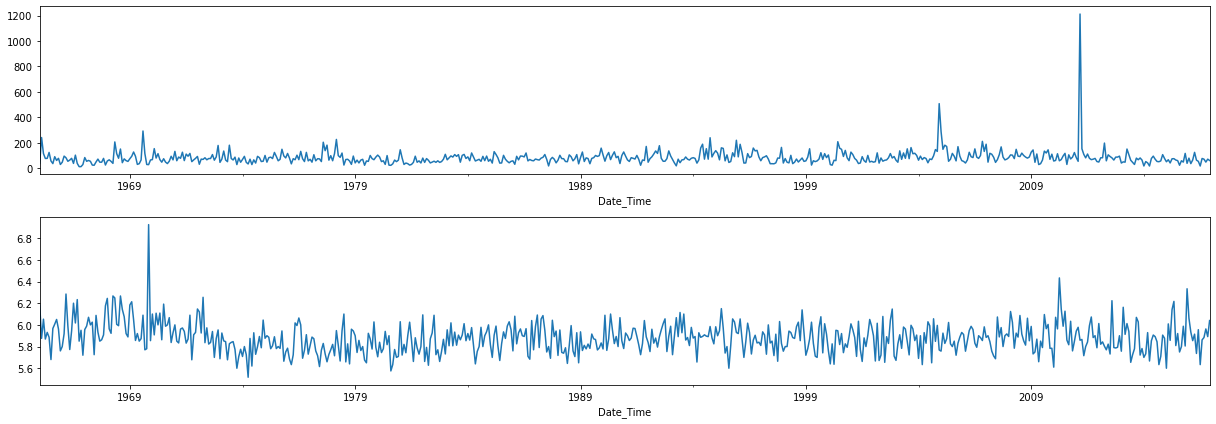

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax = axs[0]
monthly_sum_asian.plot(ax=ax)
ax=axs[1]
monthly_mean_asian.plot(ax=ax);

#### Dickey-Fuller

In [43]:
from statsmodels.tsa.stattools import adfuller

def run_df(ts):
    df_rslt = adfuller(ts)
    print("Dickey_Fuller test results:  \n")
    df_output = pd.Series(df_rslt[0:4], index=['Test Statistic','p-value',\
                                              '#Lags Used','Number of Observations Used'])
    for key, value in df_rslt[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

# $\color{red}{\text{Not sure if I need to run the DF test on the monthly mean,or the whole asian TS.  Ask Jelly/Max}}$

In [44]:
run_df(asian_ts)

Dickey_Fuller test results:  

Test Statistic                  -20.419307
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    8789.000000
Critical Value (1%)              -3.431094
Critical Value (5%)              -2.861869
Critical Value (10%)             -2.566945
dtype: float64


In [45]:
run_df(monthly_mean_asian)

Dickey_Fuller test results:  

Test Statistic                  -4.835440
p-value                          0.000047
#Lags Used                       8.000000
Number of Observations Used    615.000000
Critical Value (1%)             -3.441028
Critical Value (5%)             -2.866251
Critical Value (10%)            -2.569279
dtype: float64


In [46]:
# Let's do the same thing now, but with the data resampled as "Daily"

daily_sum_asian = asian_ts.resample('D').sum()

daily_mean_asian = asian_ts.resample('D').mean()

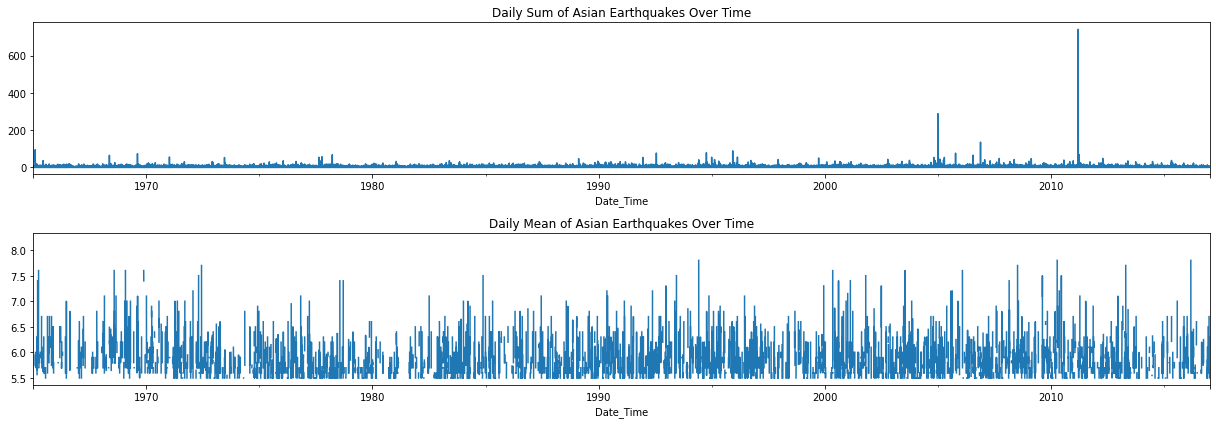

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax=axs[0]

daily_sum_asian.plot(ax=ax)
ax.set_title('Daily Sum of Asian Earthquakes Over Time')
ax=axs[1]
daily_mean_asian.plot(ax=ax)
ax.set_title('Daily Mean of Asian Earthquakes Over Time');

In [48]:
# and now "weekly"

weekly_sum_asian = asian_ts.resample('W').sum()

weekly_mean_asian = asian_ts.resample('W').mean()

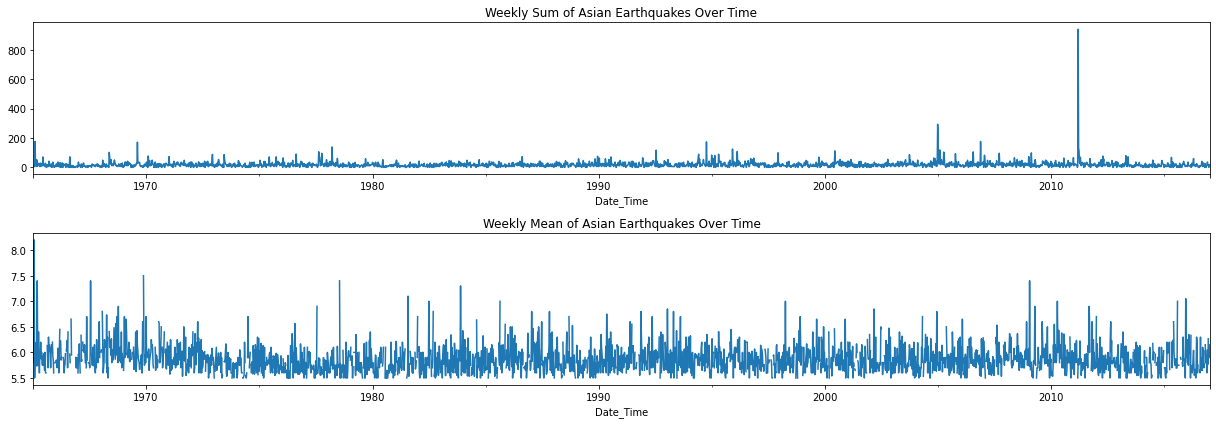

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(17,6), tight_layout=True)

ax=axs[0]

weekly_sum_asian.plot(ax=ax)
ax.set_title('Weekly Sum of Asian Earthquakes Over Time')
ax=axs[1]
weekly_mean_asian.plot(ax=ax)
ax.set_title('Weekly Mean of Asian Earthquakes Over Time');

### Let's do a train/test split on the weekly mean data:

In the case of time series, a random sampling of test samples is not going to work, so we'll just take the most recent 20% as the test, and the older 80% as the train

In [50]:
cutoff = round(weekly_mean_asian.shape[0] * 0.8)

In [51]:
train = weekly_mean_asian[:cutoff]
test = weekly_mean_asian[cutoff:]

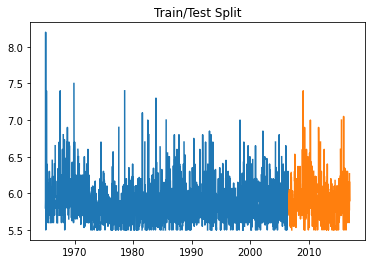

In [52]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train/Test Split');

# First Simple Model (FSM) => Random Walk

In [53]:
# The "shift" operator predicts where the next point (week) will be
random_walk = train.shift(1)

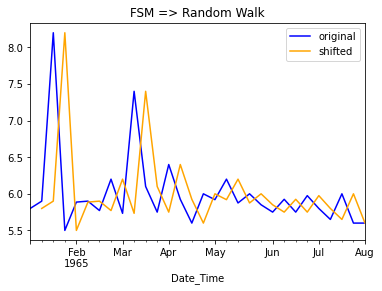

In [54]:
# plot the Random Walk:

fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='blue', label='original')
random_walk[0:30].plot(ax=ax, c='orange', label='shifted')
ax.set_title('FSM => Random Walk')
ax.legend();

For a baseline to compare with future models, the RMSE will be needed:

In [55]:
np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))

0.37537675871901716

RMSE calculated a different way, in order to plot residuals:

In [56]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

0.3400342492269958

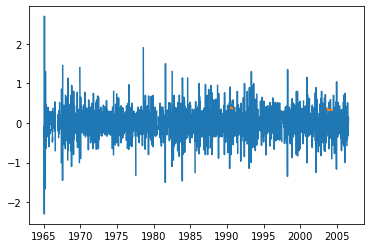

In [57]:
# plotting residuals:

fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(52).std());

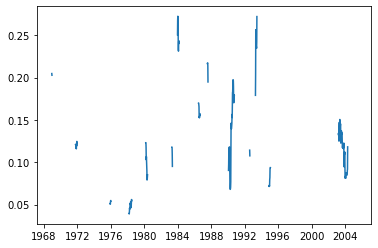

In [58]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

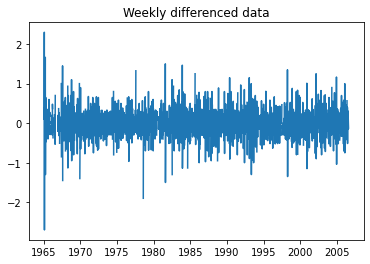

In [59]:
# Differenced data (more like white noise):

fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

# Trying a "second" FSM with monthly means instead of weekly

In [60]:
monthly_mean_asian = asian_ts.resample('MS').mean()

In [61]:
cutoff = round(monthly_mean_asian.shape[0] * 0.8)

In [62]:
train = monthly_mean_asian[:cutoff]
test = monthly_mean_asian[cutoff:]

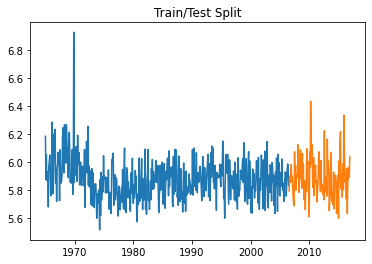

In [63]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train/Test Split');

In [64]:
train

Date_Time
1965-01-01    6.183333
1965-02-01    5.875610
1965-03-01    6.052632
1965-04-01    5.869231
1965-05-01    5.930769
                ...   
2006-03-01    5.854545
2006-04-01    5.947619
2006-05-01    5.986667
2006-06-01    5.957143
2006-07-01    5.830769
Freq: MS, Name: Magnitude, Length: 499, dtype: float64

In [65]:
random_walk = train.shift(1)

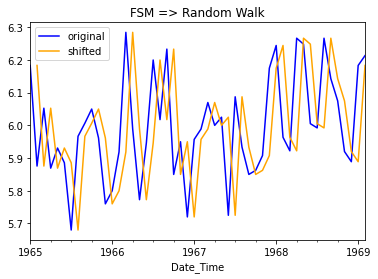

In [66]:
fig, ax = plt.subplots()

train[0:50].plot(ax=ax, c='blue', label='original')
random_walk[0:50].plot(ax=ax, c='orange', label='shifted')
ax.set_title('FSM => Random Walk')
ax.legend();

In [67]:
np.sqrt(mean_squared_error(train.dropna()[1:], random_walk.dropna()))

0.1832753541487922

In [68]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

0.1832753541487922

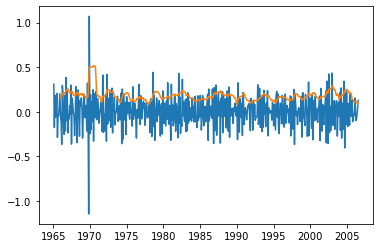

In [69]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(12).std());

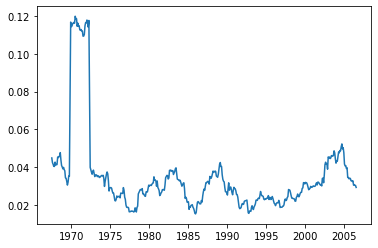

In [70]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

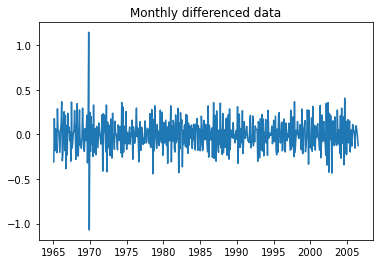

In [71]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

# ARIMA
##### AR:  The prediction that today will be like previous days, with statsmodels object "p"
##### MA:  Moving average, accounts for short-run autocorrelation, with statsmodels object "q"
             "q" can be estimated from ACF plots

In [72]:
# Using Monthly data here (train2)

ar_1 = ARIMA(train, order=(1,1,0)).fit()
ar_1.predict(typ='levels')

Date_Time
1965-01-01    0.000000
1965-02-01    6.183333
1965-03-01    6.027948
1965-04-01    5.964997
1965-05-01    5.960023
                ...   
2006-03-01    5.833364
2006-04-01    5.806327
2006-05-01    5.901543
2006-06-01    5.967336
2006-07-01    5.971759
Freq: MS, Name: predicted_mean, Length: 499, dtype: float64

In [73]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 208.010
Date:                Thu, 25 Nov 2021   AIC                           -412.021
Time:                        09:36:02   BIC                           -403.599
Sample:                    01-01-1965   HQIC                          -408.716
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4950      0.030    -16.543      0.000      -0.554      -0.436
sigma2         0.0254      0.001     28.774      0.000       0.024       0.027
===================================================================================
Ljung-Box (L1) (Q):                  12.42   Jarque-Bera (JB):               496.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.71
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
ar_1.aic

-412.02060693033127

In [75]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 138.358
Date:                Thu, 25 Nov 2021   AIC                           -274.716
Time:                        09:36:02   BIC                           -270.505
Sample:                    01-01-1965   HQIC                          -273.063
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0336      0.001     27.922      0.000       0.031       0.036
===================================================================================
Ljung-Box (L1) (Q):                 121.66   Jarque-Bera (JB):               377.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
print(f'Random Walk AIC:  {random_walk_model.aic}')
print(f'AR(1,1,0) AIC: {ar_1.aic}')

Random Walk AIC:  -274.71574799612824
AR(1,1,0) AIC: -412.02060693033127


In [77]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.319367085014753

In [78]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

0.33187799602686885

In [79]:
ar_1.arparams

array([-0.49504772])

In [80]:
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())
print(lr.coef_)

[-0.49324456]


In [81]:
ar_2 = ARIMA(train, order=(2,1,0)).fit()
ar_2.predict(typ='levels')

Date_Time
1965-01-01    0.000000
1965-02-01    6.183333
1965-03-01    6.027875
1965-04-01    6.036017
1965-05-01    5.932162
                ...   
2006-03-01    5.863983
2006-04-01    5.840454
2006-05-01    5.855310
2006-06-01    5.931105
2006-07-01    5.963872
Freq: MS, Name: predicted_mean, Length: 499, dtype: float64

In [82]:
ma_1 = ARIMA(train, order=(0,0,1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

Date_Time
1965-01-01    5.877438
1965-02-01    5.916327
1965-03-01    5.872177
1965-04-01    5.900763
1965-05-01    5.873363
                ...   
2006-03-01    5.861437
2006-04-01    5.876548
2006-05-01    5.886625
2006-06-01    5.890369
2006-07-01    5.886069
Freq: MS, Name: predicted_mean, Length: 499, dtype: float64

In [83]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 272.566
Date:                Thu, 25 Nov 2021   AIC                           -539.132
Time:                        09:36:03   BIC                           -526.494
Sample:                    01-01-1965   HQIC                          -534.172
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8774      0.008    765.977      0.000       5.862       5.892
ma.L1          0.1293      0.045      2.848      0.004       0.040       0.218
sigma2         0.0196      0.001     28.700      0.000       0.018       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               786.57
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
ma_1 = ARIMA(train, order=(0,1,1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

-274.71574799612824
-412.02060693033127
-464.55269261006816
-587.5244678402162


In [85]:
ma_2 = ARIMA(train, order=(0,1,2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

Date_Time
1965-01-01    0.000000
1965-02-01    6.183333
1965-03-01    6.031180
1965-04-01    6.036079
1965-05-01    5.995834
                ...   
2006-03-01    5.859379
2006-04-01    5.857735
2006-05-01    5.862627
2006-06-01    5.870614
2006-07-01    5.876972
Freq: MS, Name: predicted_mean, Length: 499, dtype: float64

In [86]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

-274.71574799612824
-412.02060693033127
-464.55269261006816
-587.5244678402162
-585.6031773182058


In [88]:
arma_21 = ARIMA(train, order=(2,1,2)).fit()

In [89]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

-274.71574799612824
-412.02060693033127
-464.55269261006816
-587.5244678402162
-585.6031773182058
-581.6171524317571


## ACF and PACF

F:\Flatiron\Anaconda2\envs\learn-env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


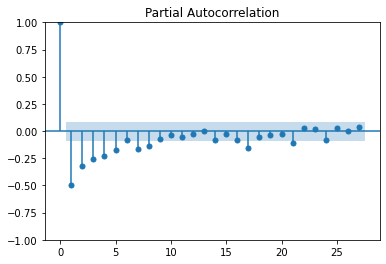

In [90]:
plot_pacf(train.diff().dropna());

In [91]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df.head()

,lag_0,lag_1
Date_Time,,
1965-01-01,6.183333,NaN
1965-02-01,5.875610,6.183333
1965-03-01,6.052632,5.875610
1965-04-01,5.869231,6.052632
1965-05-01,5.930769,5.869231


In [92]:
gamma_1 = sum(((df['lag_0'][1:]-df['lag_0'][1:].mean()) *\
               (df['lag_1'].dropna()-df['lag_1'].dropna().mean())))/(len(df['lag_1'])-1)
gamma_1

0.003193716358225281

In [93]:
rho = gamma_1/(df.lag_0[1:].std(ddof=0)*df.lag_1.std(ddof=0))
rho

0.15978023369164587

In [94]:
df = pd.DataFrame(train)
df.columns = ['lag_0']
df['lag_1'] = train.shift()
df['lag_2'] = train.shift(2)
df['lag_3'] = train.shift(3)
df['lag_4'] = train.shift(4)
df['lag_5'] = train.shift(5)
df.corr()

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
lag_0,1.000000,0.159780,0.152912,0.140931,0.158157,0.188154
lag_1,0.159780,1.000000,0.160217,0.153527,0.141306,0.158074
lag_2,0.152912,0.160217,1.000000,0.159481,0.153044,0.141539
lag_3,0.140931,0.153527,0.159481,1.000000,0.158836,0.153391
lag_4,0.158157,0.141306,0.153044,0.158836,1.000000,0.159041
lag_5,0.188154,0.158074,0.141539,0.153391,0.159041,1.000000


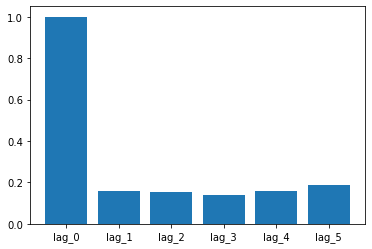

In [95]:
list(df.corr()['lag_0'].index)
plt.bar(list(df.corr()['lag_0'].index), list(df.corr()['lag_0']));

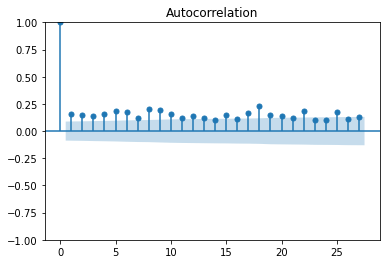

In [96]:
plot_acf(train);

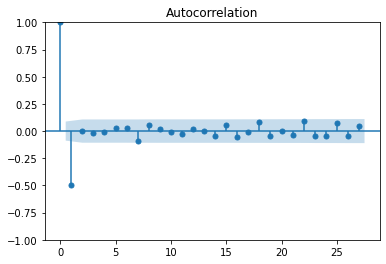

In [97]:
plot_acf(train.diff().dropna());

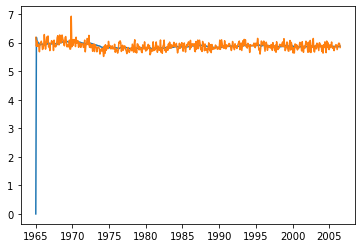

In [98]:
aa_model = ARIMA(train, order=(1, 1, 2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

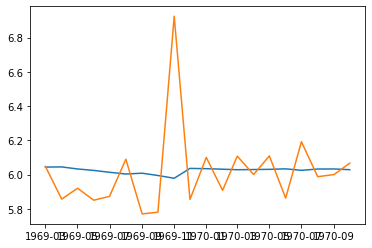

In [99]:
fig, ax = plt.subplots()
ax.plot(y_hat_train[50:70])
ax.plot(train[50:70]);

In [100]:
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Magnitude   No. Observations:                  499
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 295.777
Date:                Thu, 25 Nov 2021   AIC                           -583.554
Time:                        09:47:59   BIC                           -566.711
Sample:                    01-01-1965   HQIC                          -576.944
                         - 07-01-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5637      4.134     -0.136      0.892      -8.667       7.539
ma.L1         -0.3750      4.149     -0.090      0.928      -8.507       7.757
ma.L2         -0.5195      3.872     -0.134      0.893      -8.108       7.069
sigma2         0.0178      0.001     24.703      0.000       0.016       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               440.55
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
test

Date_Time
2006-08-01    5.793333
2006-09-01    5.900000
2006-10-01    5.882353
2006-11-01    5.855556
2006-12-01    5.981818
                ...   
2016-08-01    5.861538
2016-09-01    5.883333
2016-10-01    5.962500
2016-11-01    5.891667
2016-12-01    6.040000
Freq: MS, Name: Magnitude, Length: 125, dtype: float64

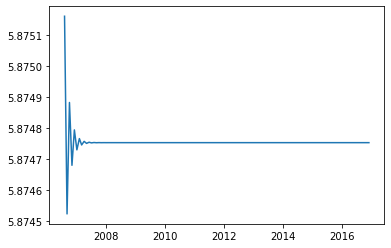

In [102]:
y_hat_test = aa_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_test);

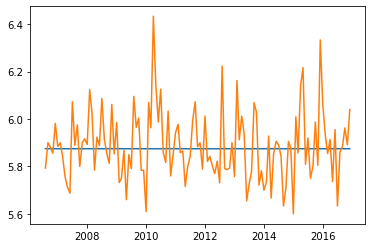

In [103]:
fig, ax = plt.subplots()
ax.plot(y_hat_test)
ax.plot(test);

In [104]:
np.sqrt(mean_squared_error(test, y_hat_test))

0.14526610135342147

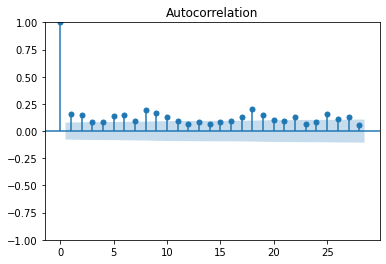

In [106]:
plot_acf(monthly_mean_asian);

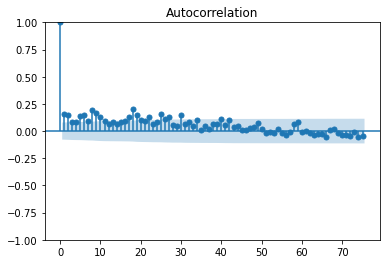

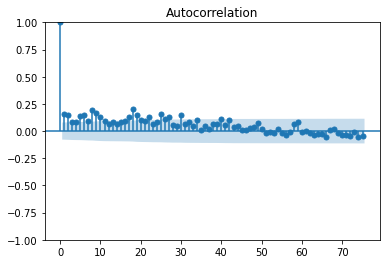

In [107]:
plot_acf(monthly_mean_asian, lags=75)

In [114]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (1, 1, 0) x (0, 1, 0, 12)
SARIMAX: (1, 1, 0) x (0, 1, 1, 12)
SARIMAX: (1, 1, 0) x (1, 1, 0, 12)
SARIMAX: (1, 1, 0) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (0, 1, 0, 12)
SARIMAX: (1, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 0, 12)
SARIMAX: (1, 1, 1) x (1, 1, 1, 12)


In [115]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:64.0416334808048
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:-228.29191121362717
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:-58.11027825234624
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:-212.58823701695124
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:-245.57289422021995
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:-520.8030066998713
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:-367.4399330690947
ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:-511.4361789464797
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:-68.86163668236412
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:-358.9967672256092
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:-188.08919109492263
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:-356.9967599493514
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:-244.3247408168619
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:-518.849315322187
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:-364.8757972106052
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:-509.6673977122034


In [116]:
sari_mod =SARIMAX(train,
                  order=(0,1,1),
                  seasonal_order=(0, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

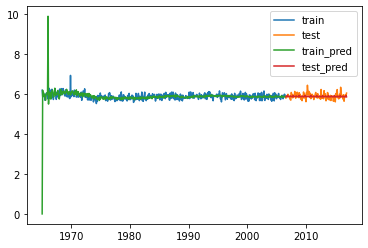

In [117]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

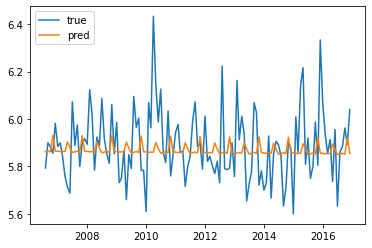

In [118]:
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [119]:
np.sqrt(mean_squared_error(test, y_hat_test))

0.1497660923537459

In [121]:
sari_mod = SARIMAX(monthly_mean_asian,
                  order=(0, 1, 1),
                  seasonal_order=(0, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [122]:
forecast = sari_mod.forecast(steps=24)

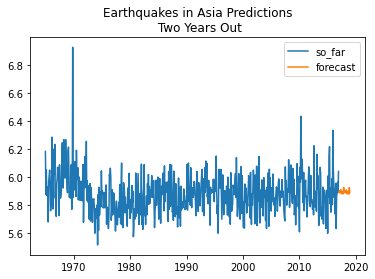

In [124]:
fig, ax = plt.subplots()

ax.plot(monthly_mean_asian, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Earthquakes in Asia Predictions\n Two Years Out')

plt.legend();